In [1]:
import numpy as np
from scipy.stats import geom
from itertools import product
from quantecon import MarkovChain
from collections import namedtuple

# NamedTuple Model
Model = namedtuple("Model", ("S", "s", "p", "φ", "h"))

def create_inventory_model(S=100,   # Order size
                           s=10,    # Order threshold
                           p=0.4):  # Demand parameter
    φ = geom(p, loc=-1) # loc sets support to {0,1,...}
    h = lambda x, d: max(x - d, 0) + S*(x <= s)
    return Model(S=S, s=s, p=p, φ=φ, h=h)


def sim_inventories(model, ts_length=200):
    """Simulate the inventory process."""
    S, s, p, φ, h = model
    X = np.empty(ts_length)
    X[0] = S  # Initial condition
    for t in range(0, ts_length - 1):
        X[t+1] = h(X[t], φ.rvs())
    return X


def compute_mc(model, d_max=100):
    """Compute the transition probabilities and state."""
    S, s, p, φ, h = model
    n = S + s + 1  # Size of state space
    state_vals = np.arange(n)
    P = np.empty((n, n))
    for (i, j) in product(range(0, n), range(0, n)):
        P[i, j] = sum((h(i, d) == j)*φ.pmf(d) for d in range(d_max+1))
    return MarkovChain(P, state_vals)


def compute_stationary_dist(model):
    """Compute the stationary distribution of the model."""
    mc = compute_mc(model)
    return mc.state_values, mc.stationary_distributions[0]



# Plots

import matplotlib.pyplot as plt


default_model = create_inventory_model()


def plot_ts(model, fontsize=16,
                   figname="../figures/inventory_sim_1.pdf",
                   savefig=False):
    S, s, p, φ, h = model
    X = sim_inventories(model)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(X, label=r"$X_t$", linewidth=3, alpha=0.6)
    fontdict = {'fontsize': fontsize}
    ax.set_xlabel(r"$t$", fontdict=fontdict)
    ax.set_ylabel("inventory", fontdict=fontdict)
    ax.legend(fontsize=fontsize, frameon=False)
    ax.set_ylim(0, S + s + 20)

    if savefig:
        fig.savefig(figname)


def plot_hist(model, fontsize=16,
                   figname="../figures/inventory_sim_2.pdf",
                   savefig=False):
    S, s, p, φ, h = model
    state_values, ψ_star = compute_stationary_dist(model)
    X = sim_inventories(model, 1_000_000)
    histogram = [np.mean(X == i) for i in state_values]

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(state_values, ψ_star, "k-",  linewidth=3, alpha=0.7,
                label=r"$\psi^*$")
    ax.bar(state_values, histogram, alpha=0.7, label="frequency")
    fontdict = {'fontsize': fontsize}
    ax.set_xlabel("state", fontdict=fontdict)

    ax.legend(fontsize=fontsize, frameon=False)
    ax.set_ylim(0, 0.015)

    if savefig:
        fig.savefig(figname)

In [2]:
model = create_inventory_model()

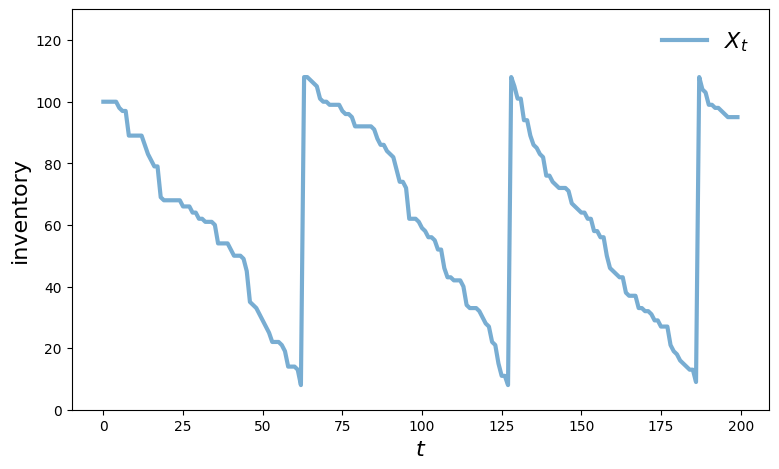

In [3]:
plot_ts(model, savefig=True)

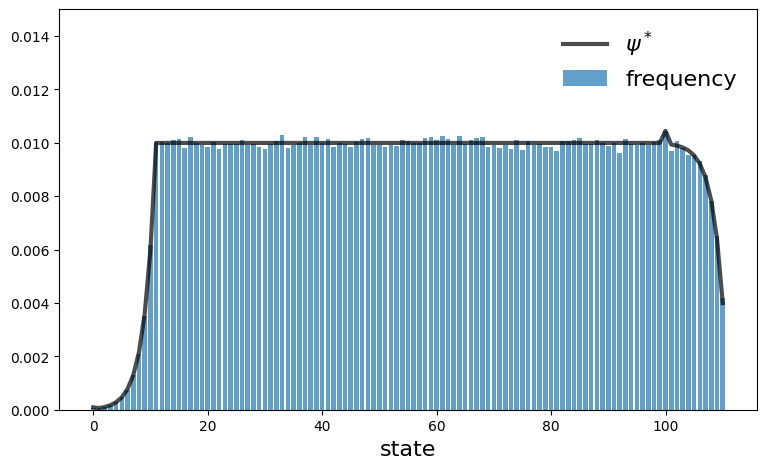

In [4]:
plot_hist(model, savefig=True)

In [5]:
from quantecon import MarkovChain
import numpy as np

P = np.array([
    [0.1, 0.9],
    [0.0, 1.0]
])

mc = MarkovChain(P)
print(mc.is_irreducible)

False


In [6]:
import numpy as np
from collections import namedtuple


# NamedTuple Model
Model = namedtuple("Model", ("α", "β"))


def create_laborer_model(α=0.3, β=0.2):
    return Model(α=α, β=β)


def laborer_update(x, model):  # update X from t to t+1
    if x == 1:
        x_ = 2 if np.random.rand() < model.α else 1
    else:
        x_ = 1 if np.random.rand() < model.β else 2
    return x_


def sim_chain(k, p, model):
    X = np.empty(k)
    X[0] = 1 if np.random.rand() < p else 2
    for t in range(0, k-1):
        X[t+1] = laborer_update(X[t], model)
    return X


def test_convergence(k=10_000_000, p=0.5):
    model = create_laborer_model()
    α, β = model
    ψ_star = (1/(α + β)) * np.array([β, α])
    X = sim_chain(k, p, model)
    ψ_e = (1/k) * np.array([sum(X == 1), sum(X == 2)])
    error = np.max(np.abs(ψ_star - ψ_e))
    approx_equal = np.allclose(ψ_star, ψ_e, rtol=0.01)
    print(f"Sup norm deviation is {error}")
    print(f"Approximate equality is {approx_equal}")

In [7]:
"""
Infinite-horizon job search with Markov wage draws.

"""

from quantecon.markov import tauchen
import numpy as np
from collections import namedtuple
from s_approx import successive_approx


# NamedTuple Model
Model = namedtuple("Model", ("n", "w_vals", "P", "β", "c"))

def create_markov_js_model(
        n=200,       # wage grid size
        ρ=0.9,       # wage persistence
        ν=0.2,       # wage volatility
        β=0.98,      # discount factor
        c=1.0        # unemployment compensation
    ):
    """
    Creates an instance of the job search model with Markov wages.
    """
    mc = tauchen(ρ, ν, n=n)
    w_vals, P = np.exp(mc.state_values), mc.P
    return Model(n=n, w_vals=w_vals, P=P, β=β, c=c)


def T(v, model):
    """
    The Bellman operator Tv = max{e, c + β P v} with e(w) = w / (1-β).
    """
    n, w_vals, P, β, c = model
    h = c + β * np.dot(P, v)
    e = w_vals / (1 - β)
    return np.maximum(e, h)


def get_greedy(v, model):
    """Get a v-greedy policy."""
    n, w_vals, P, β, c = model
    σ = w_vals / (1 - β) >= c + β * np.dot(P, v)
    return σ



def vfi(model):
    """Solve the infinite-horizon Markov job search model by VFI."""
    v_init = np.zeros(model.w_vals.shape)
    v_star = successive_approx(lambda v: T(v, model), v_init)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star



# == Policy iteration == #


def get_value(σ, model):
    """Get the value of policy σ."""
    n, w_vals, P, β, c = model
    e = w_vals / (1 - β)
    K_σ = β * ((1 - σ) * P.T).T
    r_σ = σ * e + (1 - σ) * c
    I = np.identity(K_σ.shape[0])
    return np.linalg.solve((I - K_σ), r_σ)


def policy_iteration(model):
    """
    Howard policy iteration routine.
    """
    σ = np.zeros(model.n, dtype=bool)
    i, error = 0, True
    while error:
        v_σ = get_value(σ, model)
        σ_new = get_greedy(v_σ, model)
        error = np.any(σ_new ^ σ)
        σ = σ_new
        i = i + 1
        print(f"Concluded loop {i} with error: {error}.")
    return σ


# == Plots == #

import matplotlib.pyplot as plt


default_model = create_markov_js_model()


def plot_main(model=default_model,
               method="vfi",
               savefig=False,
               figname="../figures/markov_js_vfix.png"):
    n, w_vals, P, β, c = model

    if method == "vfi":
        v_star, σ_star = vfi(model)
    else:
        σ_star = policy_iteration(model)
        v_star = get_value(σ_star, model)

    h_star = c + β * np.dot(P, v_star)
    e = w_vals / (1 - β)

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(w_vals, h_star, linewidth=4, ls="--", alpha=0.4, label=r"$h^*(w)$")
    ax.plot(w_vals, e, linewidth=4, ls="--", alpha=0.4, label=r"$w/(1-\beta)$")
    ax.plot(w_vals, np.maximum(e, h_star), "k-", alpha=0.7, label=r"$v^*(w)$")
    ax.legend(frameon=False)
    ax.set_xlabel(r"$w$")
    if savefig:
        fig.savefig(figname)

TypeError: tauchen() got multiple values for argument 'n'

In [8]:
plot_main(savefig=True)

NameError: name 'plot_main' is not defined

In [9]:
"""
Infinite-horizon job search with Markov wage draws and separation.

"""

from quantecon.markov import tauchen
import numpy as np
from collections import namedtuple
from s_approx import successive_approx


# NamedTuple Model
Model = namedtuple("Model", ("n", "w_vals", "P", "β", "c", "α"))


def create_js_with_sep_model(
        n=200,          # wage grid size
        ρ=0.9, ν=0.2,   # wage persistence and volatility
        β=0.98, α=0.1,  # discount factor and separation rate
        c=1.0):         # unemployment compensation
    """Creates an instance of the job search model with separation."""
    mc = tauchen(ρ, ν, n=n)
    w_vals, P = np.exp(mc.state_values), mc.P
    return Model(n=n, w_vals=w_vals, P=P, β=β, c=c, α=α)


def T(v, model):
    """The Bellman operator for the value of being unemployed."""
    n, w_vals, P, β, c, α = model
    d = 1 / (1 - β * (1 - α))
    accept = d * (w_vals + α * β * np.dot(P, v))
    reject = c + β * np.dot(P, v)
    return np.maximum(accept, reject)


def get_greedy(v, model):
    """ Get a v-greedy policy."""
    n, w_vals, P, β, c, α = model
    d = 1 / (1 - β * (1 - α))
    accept = d * (w_vals + α * β * np.dot(P, v))
    reject = c + β * np.dot(P, v)
    σ = accept >= reject
    return σ


def vfi(model):
    """Solve by VFI."""
    v_init = np.zeros(model.w_vals.shape)
    v_star = successive_approx(lambda v: T(v, model), v_init)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star



# == Plots == #

import matplotlib.pyplot as plt


default_model = create_js_with_sep_model()


def plot_main(model=default_model,
              savefig=False,
              figname="../figures/markov_js_with_sep_1.pdf"):
    n, w_vals, P, β, c, α = model
    v_star, σ_star = vfi(model)

    d = 1 / (1 - β * (1 - α))
    accept = d * (w_vals + α * β * np.dot(P, v_star))
    h_star = c + β * np.dot(P, v_star)

    w_star = np.inf
    for (i, w) in enumerate(w_vals):
        if accept[i] >= h_star[i]:
            w_star = w
            break

    assert w_star != np.inf, "Agent never accepts"

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(w_vals, h_star, linewidth=4, ls="--", alpha=0.4,
            label="continuation value")
    ax.plot(w_vals, accept, linewidth=4, ls="--", alpha=0.4,
            label="stopping value")
    ax.plot(w_vals, v_star, "k-", alpha=0.7, label=r"$v_u^*(w)$")
    ax.legend(frameon=False)
    ax.set_xlabel(r"$w$")
    if savefig:
        fig.savefig(figname)


def plot_w_stars(α_vals=np.linspace(0.0, 1.0, 10),
                 savefig=False,
                 figname="../figures/markov_js_with_sep_2.pdf"):

    w_star_vec = np.empty_like(α_vals)
    for (i_α, α) in enumerate(α_vals):
        print(i_α, α)
        model = create_js_with_sep_model(α=α)
        n, w_vals, P, β, c, α = model
        v_star, σ_star = vfi(model)

        d = 1 / (1 - β * (1 - α))
        accept = d * (w_vals + α * β * np.dot(P, v_star))
        h_star = c + β * np.dot(P, v_star)

        w_star = np.inf
        for (i_w, w) in enumerate(w_vals):
            if accept[i_w] >= h_star[i_w]:
                w_star = w
                break

        assert w_star != np.inf, "Agent never accepts"
        w_star_vec[i_α] = w_star

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(α_vals, w_star_vec, linewidth=2, alpha=0.6,
            label="reservation wage")
    ax.legend(frameon=False)
    ax.set_xlabel(r"$\alpha$")
    ax.set_xlabel(r"$w$")
    if savefig:
        fig.savefig(figname)

TypeError: tauchen() got multiple values for argument 'n'

In [10]:
plot_main(savefig=True)

NameError: name 'plot_main' is not defined

In [11]:
plot_w_stars(savefig=True)

NameError: name 'plot_w_stars' is not defined